In [83]:
import pandas as pd
import json
from IPython.display import SVG
import datetime

## Can we draw SVG in a notebook?

* Need to put the SVG dimensions in the `<svg>` attribute def (not in the style)
* Need the style inside the SVG block
* Not sure I need the dreadful `/* <![CDATA[ */` / `/* ]]> */` surrounding the style, this is scary

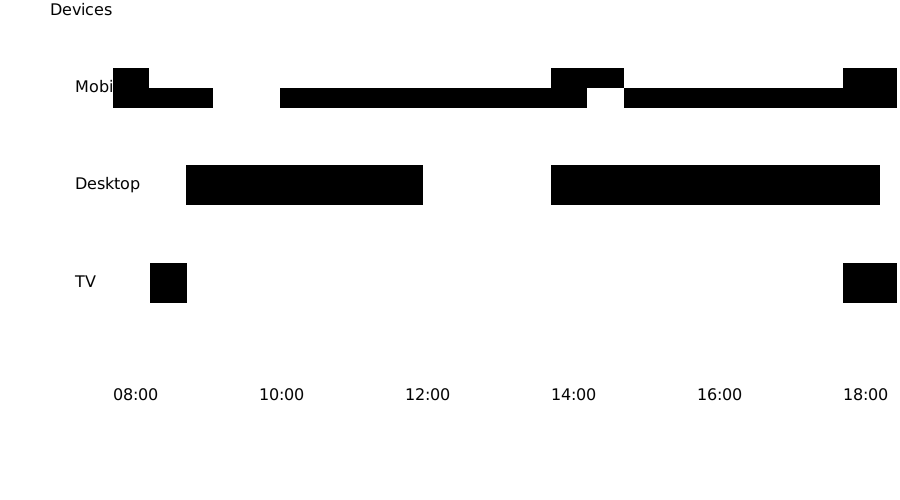

In [33]:
timeline_svg = open('timeline.svg').read()
SVG(timeline_svg)

## Now build it from the data!

First copy-paste the code in `/server/esquads_frontend/esquads_frontend/_gen_svg_timeline.py`:

In [283]:
import pandas as pd
import json
import datetime

toggle_event_types = {
    'charging': ['plugged_in', 'plugged_off'],
    'connected': ['connected', 'disconnected']
}

svg_style = '''<style type="text/css">
/* <![CDATA[ */
svg .grid {
  stroke: grey;
  stroke-dasharray: 1 2;
  stroke-width: 1;
}
svg .grid .axis {
  stroke: grey;
  stroke-dasharray: 0;
  stroke-width: 2;
}
svg .labels {
  font-family: Arial;
  font-size: 14px;
}
svg .labels.xlabels {
  text-anchor: middle;
}
svg .labels.ylabels {
  text-anchor: end;
}
svg .labels .title {
  text-anchor: start;
  font-size: 16px;
}

svg .bars .connected {
  stroke: none;
  fill: turquoise;
  fill-opacity: 0.5;
}
svg .bars .charging {
  stroke: none;
  fill: green;
  fill-opacity: 0.5;
}
svg .bars .available {
  stroke: black;
  fill: gray;
  fill-opacity: 0.2;
  stroke-opacity: 1;
}
svg .bars .legend {
  fill: black;
  fill-opacity: 1;
  text-anchor: end;
  font-size: 12px;
}
/* ]]> */
</style>'''


def gen_svg_timeline(user_data_dict):
    print("Generating stuffs")
    user_data_df = pd.DataFrame(user_data_dict['events'])
    if len(user_data_df) == 0:
        return None

    user_data_df = user_data_df.drop(columns=['user_token'], errors='ignore')
    user_data_df['local_time'] = pd.to_datetime(user_data_df['local_time'])

    t0, t_final = compute_time_interval(user_data_df)
    event_series = compute_event_series(user_data_df, t0, t_final)

    #############################
    # Global graphics variables #
    #############################

    # X & Y ticks
    devices = user_data_df['device_token'].unique()
    ylabels = user_data_df.groupby('device_token').first()[
        'device_type'].values
    yticks = [None]
    yticks.extend(ylabels)
    n_devices = len(devices)
    n_xticks = 6
    xticks = pd.date_range(t0, t_final, n_xticks).floor('min')

    # General height definitions
    axis_height = 80
    event_bar_height = 20
    avail_bar_height = event_bar_height * 2
    ytick_height = avail_bar_height * 2
    plot_padding_height = ytick_height // 4
    plot_height = n_devices * ytick_height + plot_padding_height * 2
    height = axis_height + plot_height

    # General width definitions
    axis_width = 100
    plot_width = 500
    padding_right = 50
    xtick_width = plot_width // (n_xticks-1)
    xpos_legend = axis_width + plot_width - 10
    width = axis_width + plot_width + padding_right

    #####################
    # Drawing functions #
    #####################

    # X-grid (horizontal) generation
    def gen_xgrid():
        grid = '''<g class="grid xgrid" id="xGrid">\n'''
        labels = '''<g class="labels xlabels">\n'''
        ymin = 10
        ymax = plot_height + 20
        ypos_label = ymax + 20

        prev_date = None
        for i, xtick in enumerate(xticks):
            xpos = axis_width + i * xtick_width
            tick_label = f'''<tspan>{ xtick.strftime("%H:%M") }</tspan>'''
            class_ = ""
            if i == 0:
                class_ = ''' class="axis yaxis"'''

            # Add date to label when it changes
            curr_date = xtick.strftime("%y-%m-%d")
            if curr_date != prev_date:
                tick_label += f'''<tspan  x="{ xpos }" dy="1.2em">{ curr_date }</tspan>'''

            prev_date = curr_date

            grid += f'''  <line x1="{ xpos }" x2="{ xpos }" y1="{ ymin }" y2="{ ymax }"{ class_ }></line>\n'''
            labels += f'''  <text x="{ xpos }" y="{ ypos_label }">{ tick_label }</text>\n'''

        # Axis title
        labels += f'''  <text class="title" x="0" y="{ ypos_label }">Time:</text>\n'''

        grid += '''</g>\n'''
        labels += '''</g>\n'''
        return grid + labels

    # Y-grid (vertical) generation
    def gen_ygrid():
        grid = '''<g class="grid ygrid" id="yGrid">\n'''
        labels = '''<g class="labels xlabels">\n'''
        xmin = axis_width - 20
        xmax = width - 5
        xpos_label = xmin - 30

        for i, ytick in enumerate(yticks):
            ypos = height - axis_height - i * ytick_height
            class_ = ""
            if i == 0:
                class_ = ''' class="axis xaxis"'''
                tick_label = ""
            else:
                class_ = ""
                tick_label = ytick
                ypos = ypos - plot_padding_height + ytick_height/2

            grid += f'''  <line x1="{ xmin }" x2="{ xmax }" y1="{ ypos }" y2="{ ypos }"{ class_ }></line>\n'''
            labels += f'''  <text x="{ xpos_label }" y="{ ypos+4 }">{ tick_label }</text>\n'''

        # Axis title
        labels += f'''  <text class="title" x="0" y="{ plot_padding_height }">Devices:</text>\n'''

        grid += '''</g>\n'''
        labels += '''</g>\n'''
        return grid + labels

    # Generation of the event bars

    def t_to_xpos(t):
        if t < t0 or t > t_final:
            raise ValueError("Provided time is out of bounds")

        xpos = axis_width
        xpos += int((t - t0) / (t_final - t0) * plot_width)
        return xpos

    def gen_mobile_device_bars(device_series, idy):
        return ""

    def gen_avail_bars(device_series, idy):
        ret = '''<g class="available">\n'''
        ypos = height - axis_height - plot_padding_height - \
            (idy+1) * ytick_height + ytick_height/2
        ypos -= avail_bar_height / 2

        for _, row in device_series.iterrows():
            x = t_to_xpos(row['t_start'])
            w = t_to_xpos(row['t_end']) - x
            ret += f'''  <rect x="{ x }" y="{ ypos }" width="{ w }" height="{ avail_bar_height }"></rect>\n'''

        print("Stuffing ze stuffs")
        ret += f'''<text class="legend" x="{ xpos_legend }" y="{ ypos+22 }">available</text>\n'''
        ret += '''</g>\n'''
        return ret

    def gen_conn_bars(device_series, idy):
        ret = '''<g class="connected">\n'''
        ypos = height - axis_height - plot_padding_height - \
            (idy+1) * ytick_height + ytick_height // 2
        ypos -= avail_bar_height // 2

        for _, row in device_series.iterrows():
            x = t_to_xpos(row['t_start'])
            w = t_to_xpos(row['t_end']) - x
            ret += f'''  <rect x="{ x }" y="{ ypos }" width="{ w }" height="{ event_bar_height }"></rect>\n'''

        ret += f'''<text class="legend" x="{ xpos_legend }" y="{ ypos+15 }">connected</text>\n'''
        ret += '''</g>\n'''
        return ret

    def gen_charge_bars(device_series, idy):
        ret = '''<g class="charging">\n'''
        ypos = height - axis_height - plot_padding_height - \
            (idy+1) * ytick_height + ytick_height // 2

        for _, row in device_series.iterrows():
            x = t_to_xpos(row['t_start'])
            w = t_to_xpos(row['t_end']) - x
            ret += f'''  <rect x="{ x }" y="{ ypos }" width="{ w }" height="{ event_bar_height }"></rect>\n'''

        ret += f'''<text class="legend" x="{ xpos_legend }" y="{ ypos+15 }">charging</text>\n'''
        ret += '''</g>\n'''
        return ret

    def gen_devices_bars():
        ret = '''<g class="bars" data_setname="Availability timeline">\n'''

        for idy, device_token in enumerate(devices):
            device_series = event_series[event_series['device_token']
                                         == device_token]

            for event_type, s_event in device_series.groupby('event_type'):
                if event_type == 'available':
                    ret += gen_avail_bars(s_event, idy)
                elif event_type == 'connected':
                    ret += gen_conn_bars(s_event, idy)
                elif event_type == 'charging':
                    ret += gen_charge_bars(s_event, idy)

        ret += '''</g>\n'''
        return ret

    return f'''<svg width="{ width }px" height="{ height }px">
{ gen_xgrid() }
{ gen_ygrid() }
{ gen_devices_bars() }
{ svg_style }
</svg>
'''


def compute_device_event_series(df, toggle_events, t0, t_final):
    assert len(toggle_events) == 2
    series = pd.DataFrame(columns=['t_start', 't_end'])

    df['event_toggle'] = df['event_type'].replace({
        toggle_events[0]: True,
        toggle_events[1]: False
    })

    t_start = t0
    for _, row in df.iterrows():
        if row['event_toggle']:
            t_start = row['local_time']
        elif not row['event_toggle'] and t_start is not None:
            series = series.append({
                't_start': t_start,
                't_end': row['local_time']
            }, ignore_index=True)
            t_start = None

    if t_start is not None:
        series = series.append({
            't_start': t_start,
            't_end': t_final
        }, ignore_index=True)

    return series


def compute_event_series(user_data_df, t0, t_final):
    event_series = pd.DataFrame()

    for device_token, device_df in user_data_df.groupby('device_token', sort='local_time'):
        device_type = device_df['device_type'].iloc[0]

        if device_type == 'mobile':
            device_series = pd.DataFrame()

            for event_type, toggle_events in toggle_event_types.items():
                mask = device_df['event_type'].isin(toggle_events)
                df = device_df[mask]

                series = compute_device_event_series(
                    df, toggle_events, t0, t_final)
                series['device_token'] = device_token
                series['device_type'] = device_type
                series['event_type'] = event_type

                device_series = device_series.append(series, ignore_index=True)

            event_series = event_series.append(
                device_series, ignore_index=True)
        else:
            toggle_events = toggle_event_types['connected']
            mask = device_df['event_type'].isin(toggle_events)
            df = device_df[mask]

            series = compute_device_event_series(
                df, toggle_events, t0, t_final)
            series['device_token'] = device_token
            series['device_type'] = device_type
            series['event_type'] = 'available'
            event_series = event_series.append(series, ignore_index=True)
    return event_series


def compute_time_interval(user_data_df):
    initial_time_offset = datetime.timedelta(hours=2)
    t0 = user_data_df['local_time'].min() - initial_time_offset
    t_final = user_data_df['local_time'].max()
    return t0, t_final


Generating stuffs
Stuffing ze stuffs


<ipython-input-283-5809beadf229>:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_toggle'] = df['event_type'].replace({


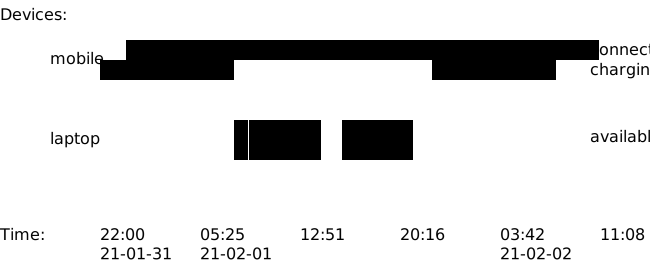

In [284]:
user_data_dict = json.load(open('user_data.json'))

SVG(gen_svg_timeline(user_data_dict))

In [264]:
user_data_df = pd.DataFrame(user_data_dict['events'])

user_data_df = user_data_df.drop(columns=['user_token'], errors='ignore')
user_data_df['local_time'] = pd.to_datetime(user_data_df['local_time'])

t0, t_final = compute_time_interval(user_data_df)
event_series = compute_event_series(user_data_df, t0, t_final)
event_series

<ipython-input-260-ad3d9ee6ea2f>:249: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_toggle'] = df['event_type'].replace({


t_start               t_end       device_token device_type  \
0 2021-02-01 08:00:00 2021-02-01 09:00:00         chou-farci      laptop   
1 2021-02-01 09:05:00 2021-02-01 14:25:33         chou-farci      laptop   
2 2021-02-01 16:00:00 2021-02-01 16:03:03         chou-farci      laptop   
3 2021-02-01 16:04:16 2021-02-01 21:16:10         chou-farci      laptop   
4 2021-01-31 22:00:00 2021-02-01 08:00:00  potager-pythagore      mobile   
5 2021-02-01 22:40:20 2021-02-02 07:55:34  potager-pythagore      mobile   
6 2021-02-01 00:00:00 2021-02-02 11:05:33  potager-pythagore      mobile   
7 2021-02-02 11:08:07 2021-02-02 11:08:07  potager-pythagore      mobile   

  event_type  
0  available  
1  available  
2  available  
3  available  
4   charging  
5   charging  
6  connected  
7  connected